In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('full_zno.csv')

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_45125/2343335949.py:1: DtypeWarning: Columns (17,20,23,26,29,32,35,38,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_zno.csv')


1. Анализ по отдельным переменным
   1.1 Годы
   1.2 Профиль участника
   1.3 География
   1.4 Предметы
2. Комбинированный анализ
   2.1 Профиль + Годы
   2.2 География + Годы
   2.3 Предметы + Годы
   2.4 Профиль + Предметы
4. Общие выводы и ключевые инсайты
5. Визуализации и дашборды

# Аналіз по окремих змінних | Analysis by individual variables | Анализ по отдельным переменным

## 1.1 Роки | Years | Годы

In [ ]:
Шаблон анализа:
Количество участников по годам
- participants_by_year, 
- participants_by_year_plot

Процент неявок по годам
- noshow_by_year

Средний / медианный балл по годам 
- by_year, 
- mean_median_by_year_plot

Стандартное отклонение 
- by_year

% высокобалльников / низкобалльников
- high_low_failed_by_year

Top–5 / Bottom–5 лет по среднему баллу
Динамика по годам: рост / падение количества участников, среднего балла, процента неявок +

### Кількість учасників за роками та частка кожного року у загальному масиві | Number of participants by year and share of each year in the total dataset | Количество участников по годам и доля каждого года в общем массиве

In [6]:
participants_count = df.groupby('Year')['Id'].count().sort_index()

In [10]:
participants_percent = (df['Year'].value_counts(normalize=True).sort_index() * 100).round(2)

In [31]:
participants_by_year = pd.concat([participants_count, participants_percent], axis=1) \
                        .reset_index().rename(columns={'Id':'count',
                                                       'proportion': '%_of_total'})

In [32]:
participants_by_year

,Year,count,%_of_total
0,2016,268003,8.59
1,2017,240889,7.72
2,2018,335687,10.76
3,2019,353813,11.34
4,2020,379299,12.16
5,2021,389323,12.48
6,2022,234104,7.50
7,2023,288935,9.26
8,2024,312508,10.02
9,2025,317091,10.16


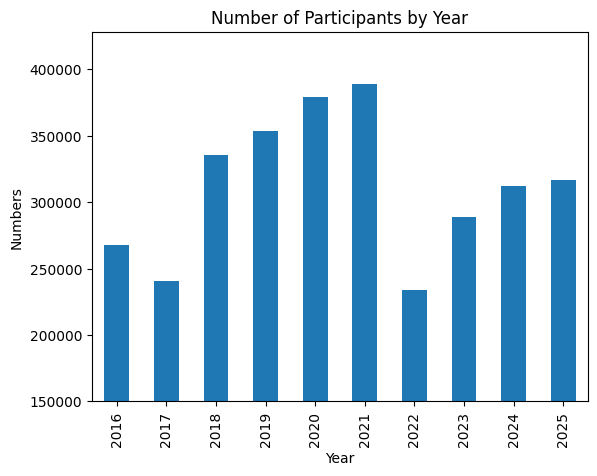

In [23]:
fig, ax1 = plt.subplots()

participants_count.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numbers')
ax1.set_ylim(150000, participants_count.max() * 1.1)
ax1.set_title('Number of Participants by Year')

participants_by_year_plot = fig

Чітко простежується зростання кількості учасників з 2016 по 2021 рік. Різке зниження у 2022 році пояснюється початком повномасштабної війни. З 2023 року спостерігається поступове відновлення активності. Порівняння 2024 і 2025 років показує практично однакову кількість учасників. Особливо цікаво буде побачити дані за 2026 рік, щоб оцінити подальший тренд з урахуванням поточної ситуації в країні

Чётко прослеживается рост числа участников с 2016 по 2021 год. Резкое снижение в 2022 году объясняется началом полномасштабной войны. С 2023 года наблюдается постепенное восстановление активности. Сравнение 2024 и 2025 годов показывает практически одинаковое количество участников. Особенно интересно будет увидеть данные за 2026 год, чтобы оценить дальнейший тренд с учётом текущей ситуации в стране.

There is a clear increase in the number of participants from 2016 to 2021. The sharp decline in 2022 is explained by the start of the full-scale war. Since 2023, a gradual recovery in activity has been observed. A comparison of 2024 and 2025 shows almost the same number of participants. It will be especially interesting to see the data for 2026 to assess the future trend given the current situation in the country.

### Відсоток неявок за роками | Percentage of no-shows by year | Процент неявок по годам

In [35]:
prefs = ('Ukr', 'Math', 'Hist', 'Eng', 'Fra', 'Deu', 'Spa', 'Phys', 'Chem', 'Bio', 'Geo', 'UkrLit')

In [36]:
df['statuses_comb'] = df[[pref + 'Status' for pref in prefs]] \
        .apply(lambda x: set(x) - {'Не складав'}, axis=1)

збираю статуси по всіх предметах в одну множину, щоб визначити відсоток учасників
за комбінацією статусів.

In [37]:
statuses_comb = df['statuses_comb'].value_counts().reset_index()

In [38]:
statuses_comb['statuses_comb'] = statuses_comb['statuses_comb'].apply(lambda x: ', '.join(x))

In [39]:
statuses_comb.iloc[7, 0] = 'Не складав'

In [40]:
statuses_comb['%_of_total'] = (statuses_comb['count'] / len(df) * 100).round(2)

Логіка така:

Зараховано — учасник подолав поріг з усіх предметів, у яких брав участь.
Не зараховано — учасник не подолав поріг ні з одного предмета.

Зараховано, Не зараховано — мінімум 1 предмет склав і мінімум 1 предмет не склав.

Не з’явився або анульовано — учасник не з’явився на жоден зареєстрований тест.

Зараховано, Не з’явився або анульовано — мінімум 1 предмет склав, мінімум на 1 предмет не з’явився.

Не зараховано, Не з’явився або анульовано — мінімум 1 предмет не склав, мінімум на 1 предмет не з’явився.

Зараховано, Не зараховано, Не з’явився або анульовано — мінімум 1 склав, мінімум 1 не склав, мінімум 1 не з’явився.

Не складав — невелика кількість учасників, які не складали. 

Але чому тоді вони є в ДФ? 
Усе тому, що насправді ці учасники складали тести, але відмовилися переводити бали в систему 100–200.
Тому для них статус «Не складав».


In [41]:
statuses_comb #за все года

,statuses_comb,count,%_of_total
0,Зараховано,2086792,66.89
1,"Зараховано, Не зараховано",460583,14.76
2,Не з'явився або анульовано,316739,10.15
3,"Зараховано, Не з'явився або анульовано",122769,3.94
4,Не зараховано,85555,2.74
5,"Зараховано, Не з'явився або анульовано, Не зар...",34212,1.10
6,"Не з'явився або анульовано, Не зараховано",10591,0.34
7,Не складав,2411,0.08


In [42]:
df['statuses_comb'] = df['statuses_comb'].apply(lambda x: ', '.join(x))

In [43]:
no_show_by_year = df[df['statuses_comb'] == "Не з'явився або анульовано"].groupby('Year')['Id'].count().reset_index()

In [44]:
total_by_year = df['Year'].value_counts().reset_index()

In [45]:
no_show_by_year_and_total = no_show_by_year.merge(total_by_year, on='Year').rename(columns={'Id':'no_show', 'count':'total_count'})

In [46]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['no_show'] / no_show_by_year_and_total['total_count'] * 100

In [47]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['%no_show_of_total'].round(1)

In [48]:
total_tests = df[[pref + 'Status' for pref in prefs] + ['Year']]

In [49]:
total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_45125/1167212966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)


In [50]:
total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_45125/2243426049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)


In [51]:
total_tests = total_tests.groupby('Year')[["Не з'явився", "count_reg_tests"]].sum().reset_index()

In [52]:
total_tests['%_of_total'] = (total_tests["Не з'явився"] / total_tests["count_reg_tests"] * 100).round(2)

In [53]:
noshow_by_year = no_show_by_year_and_total.merge(total_tests, on='Year')[['Year', 
                                                         'total_count', 'no_show', '%no_show_of_total',
                                                         'count_reg_tests', "Не з'явився", '%_of_total']]

In [58]:
old_names = list(noshow_by_year.columns)
new_names = ['Year', 'Num_of_Particip', 'Missed_All', 'Missed_All_Perc', 
             'Reg_Tests', 'Missed_Tests', 'Missed_Tests_Perc']
noshow_by_year = noshow_by_year.rename(columns=dict(zip(old_names, new_names)))

In [59]:
noshow_by_year

,Year,Num_of_Particip,Missed_all,Missed_All_Perc,Reg_Tests,Missed_Tests,Missed_Tests_Perc
0,2016,268003,12546,4.7,876061,66650,7.61
1,2017,240889,9563,4.0,836836,50723,6.06
2,2018,335687,9383,2.8,914011,46700,5.11
3,2019,353813,8952,2.5,1041699,45531,4.37
4,2020,379299,94707,25.0,1227151,314166,25.60
5,2021,389323,84184,21.6,1700962,388660,22.85
6,2022,234104,20030,8.6,702312,60090,8.56
7,2023,288935,20807,7.2,866805,62421,7.20
8,2024,312508,29138,9.3,1250032,116910,9.35
9,2025,317091,27429,8.7,1268364,109856,8.66


(Num_of_Particip, Missed_all, Missed_All_Perc) - кількість учасників, які не з’явилися на жоден із зареєстрованих тестів. 
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) кілкість тестів, на які булі зареєстровані учасники, та були прогуляні.

Особливо помітно, як у 2020 та 2021 роках цей показник значно зріс. Це пов’язано з пандемією COVID-19 та організаційним хаосом. Тестування кілька разів переносили, змінювали правила, а регіони закривали на локдауни.